# **COMP9727 Recommender Systems**
## Assignment: Content-Based Music Recommendation

Name: **Ziyang Lu**

Zid: **z5459764**


### Overview of Pipeline

**Loading the Dataset**
    - a collection of 1500 songs that have been labelled as one of 5 main topics: dark, emotion, lifestyle, personal and sadness. The songs are in a single .tsv filee with 6 fields: artist name, track name, release date, genre, lyrics and topicic
    
**Part 1**
    -  Part 1 of the assignment is to examine various supervised machine learning methods using a
 variety of features and settings to determine what methods work best for topic classification in
 this domain/dataset. For this purpose, simply concatenate all the information for one song into
 a single “document”. You will use Bernoulli Naive Bayes from the tutorial, Multinomial Naive
 Bayes from the lecture, and one other machine learning method of your choice from scikit-learn
 or another machine learning library, and NLTK for auxiliary functions if needed
 
**Part 2**
    - Part 2 of the assignment is to test a potential recommender system that uses the method for
 topic classification chosen in Part 1 by “simulating” a recommender system with a variety of
 hypothetical users. This involves evaluating a number of techniques for “matching” user profiles
 with songs using the similarity measures mentioned in the lecture. As we do not have real users,
 for this part of the assignment, we will simply “invent” some (hopefully typical) users and evaluate
 how well the recommender system would work for them, using appropriate metrics
 
**Part 3**
    - Part 3 of the assignment is to run a very small “user study” which means here finding one person,
 preferably not someone in the class, to try out your recommendation method and give some
 informal comments on the performance of your system from the user point of view. This does
 not require any user interface to be built, the user can simply be shown the output (or use) the
 Jupyter notebook from Parts 1 and 2. However, you will have to decide how many songs to show
 the user at any one time, and how to get feedback from them on which songs they would click on
 and which songs match their interests. A simple “talk aloud” protocol is a good idea here (this is
 where you ask the user to use your system and say out loud what they are thinking/doing at the
 same time– however please do not record the user’s voice– for that we need ethics approval)

__Load library__

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to D:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to D:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


__Load the Dataset__

In [ ]:
df = pd.read_csv("dataset.tsv", sep='\t')
df.head()

,artist_name,track_name,release_date,genre,lyrics,topic
0,loving,the not real lake,2016,rock,awake know go see time clear world mirror worl...,dark
1,incubus,into the summer,2019,rock,shouldn summer pretty build spill ready overfl...,lifestyle
2,reignwolf,hardcore,2016,blues,lose deep catch breath think say try break wal...,sadness
3,tedeschi trucks band,anyhow,2016,blues,run bitter taste take rest feel anchor soul pl...,sadness
4,lukas nelson and promise of the real,if i started over,2017,blues,think think different set apart sober mind sym...,dark


In [ ]:
df.isna().sum()

artist_name     0
track_name      0
release_date    0
genre           0
lyrics          0
topic           0
dtype: int64

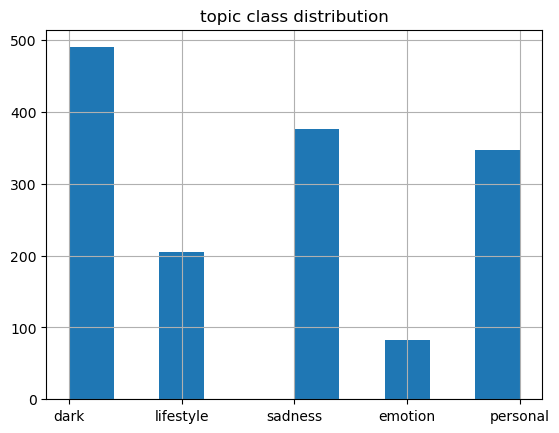

In [ ]:
plt.figure()
df.topic.hist()  # the category size of each topic class
plt.title("topic class distribution")
plt.show()

__Part 1. Topic Classification__

1. (2 marks) There are a few simplifications in the Jupyter notebook in the tutorial: (i) the regex
 might remove too many special characters, and (ii) the evaluation is based on only one training
test split rather than using cross-validation. Explain how you are going to fix these mistakes and
 then highlight any changes to the code in the answers to the next questions.

_answer_

(i) The regex in the tutorial removes everything except letters, digits, and whitespace. This means it deletes apostrophes (like ' and .), resulting in words like "rocky's" and "jr." losing their original meaning. To fix this, I will use a regex that keeps useful special characters.

(ii) As shown in the plot of "topic class distribution", the dataset is imbalanced, hence stratified k-fold (5-fold) cross-validation will be applied. 

 2. (2 marks) Develop a Multinomial Naive Bayes (MNB) model similar to the Bernoulli Naive
 Bayes (BNB) model. Now consider all the steps in text preprocessing used prior to classification
 with both BNB and MNB. 

_answer_

Because the original text in the data is all lowercase, lowercasing is not necessary. In addition, except for special characters (apostrophes), the original text does not contain commas, periods, and other separators, and each word is separated by spaces, so the split() function is enough to complete the word tokenization. Through experiments, we can find that retaining special characters (apostrophes), stemming, and removing stop words can improve the accuracy, so the final preprocessing process includes the following three steps: removing non-alphanumeric characters while keeping apostrophes, removing stopwords (NLTK) and stemming. 

In [ ]:
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r"[^\w\s'.]", '', text)  # keeps apostrophes
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

# concatenate all the information for one song into a single “document”
df['document'] = (df['artist_name'] + ' ' + df['track_name'] + ' ' + df['release_date'].astype(str) + ' ' + df['genre'] + ' ' + 
                  df['lyrics']).apply(preprocess_text)
# print(df['document'][0])

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['document'])
y = df['topic']

mnb = MultinomialNB()  # MNB model
cv = StratifiedKFold(5, shuffle=True, random_state=42)
mnb_scores = cross_val_score(mnb, X, y, cv=cv)
print("average cross-validation accuracy:", np.mean(mnb_scores).round(4))

average cross-validation accuracy: 0.7907


 3. (2 marks) Compare BNB and MNB models by evaluating them using the full dataset with
 cross-validation.

_answer_

The evaluation metrics used include accuracy, macro-average F1 score, macro-average precision, and macro-average recall. The results show that MultinomialNB outperforms BernoulliNB. Since the dataset is imbalanced, macro-average F1 score should be the preferred evaluation metric. The reason is that accuracy can only reflect the overall predictive ability of the model, while there is a trade-off between precision and recall. F1 score can comprehensively consider precision and recall, providing a more comprehensive model performance evaluation.

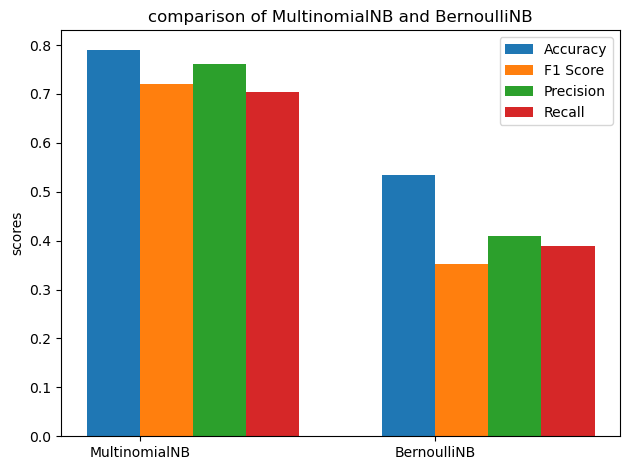

In [ ]:
cv = StratifiedKFold(5, shuffle=True, random_state=42)

mnb = MultinomialNB()  # MNB model
mnb_acc = cross_val_score(mnb, X, y, cv=cv)
mnb_f1 = cross_val_score(mnb, X, y, cv=cv, scoring='f1_macro')
mnb_precision = cross_val_score(mnb, X, y, cv=cv, scoring='precision_macro')
mnb_recall = cross_val_score(mnb, X, y, cv=cv, scoring='recall_macro')

bnb = BernoulliNB()
bnb_scores = cross_val_score(bnb, X, y, cv=cv)
bnb_acc = cross_val_score(bnb, X, y, cv=cv)
bnb_f1 = cross_val_score(bnb, X, y, cv=cv, scoring='f1_macro')
bnb_precision = cross_val_score(bnb, X, y, cv=cv, scoring='precision_macro')
bnb_recall = cross_val_score(bnb, X, y, cv=cv, scoring='recall_macro')

metrics = {
    'Accuracy': [np.mean(mnb_acc), np.mean(bnb_acc)],
    'F1 Score': [np.mean(mnb_f1), np.mean(bnb_f1)],
    'Precision': [np.mean(mnb_precision), np.mean(bnb_precision)],
    'Recall': [np.mean(mnb_recall), np.mean(bnb_recall)]
}

fig, ax = plt.subplots()
x = np.arange(2)
width = 0.18
for i, (metric_name, metric_values) in enumerate(metrics.items()):
    ax.bar(x + i * width, metric_values, width, label=metric_name)
ax.set_ylabel('scores')
ax.set_title('comparison of MultinomialNB and BernoulliNB')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(['MultinomialNB', 'BernoulliNB'])
ax.legend()

plt.tight_layout()
plt.show()

 4. (2 marks) Consider varying the number of features (words) used by BNB and MNB in the
 classification, using the sklearn setting which limits the number to the top N most frequent
 words in the Vectorizer. Compare classification results for various values for N and justify, based
 on experimental results, one value for N that works well overall and use this value for the rest
 of the assignment.

_answer_

Based on the experimental results, the best N for "top N most frequent words in the CountVectorizer" is 300.

Best N with the highest score for MNB: 300


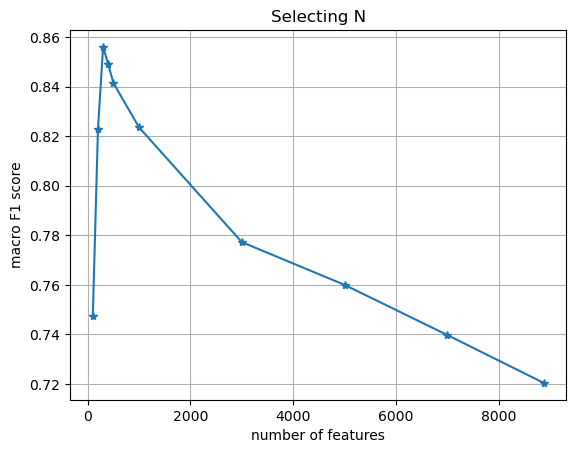

In [ ]:
results = []
for N in [100, 200, 300, 400, 500, 1000, 3000, 5000, 7000, None]:
    vec = CountVectorizer(max_features=N)
    X1 = vec.fit_transform(df['document'])
    cv = StratifiedKFold(5, shuffle=True, random_state=42)
    mnb = MultinomialNB()
    score = cross_val_score(mnb, X1, y, cv=cv, scoring='f1_macro').mean()
    results.append((len(vec.vocabulary_), score))
best_N = sorted(results, key=lambda x: x[1], reverse=True)[0][0]
print("Best N with the highest score for MNB:", best_N)

plt.figure()
plt.plot([r[0] for r in results], [r[1] for r in results], marker="*")
plt.xlabel('number of features')
plt.ylabel('macro F1 score')
plt.title('Selecting N')
plt.grid()
plt.show()

Best N with the highest score for BNB: 300


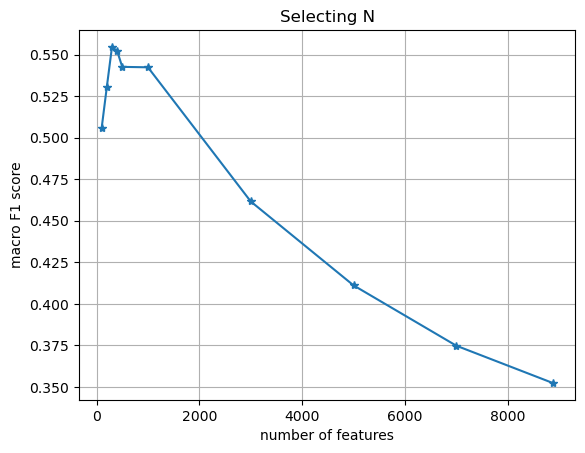

In [ ]:
results = []
for N in [100, 200, 300, 400, 500, 1000, 3000, 5000, 7000, None]:
    vec = CountVectorizer(max_features=N)
    X1 = vec.fit_transform(df['document'])
    cv = StratifiedKFold(5, shuffle=True, random_state=42)
    bnb = BernoulliNB()
    score = cross_val_score(bnb, X1, y, cv=cv, scoring='f1_macro').mean()
    results.append((len(vec.vocabulary_), score))
best_N = sorted(results, key=lambda x: x[1], reverse=True)[0][0]
print("Best N with the highest score for BNB:", best_N)

plt.figure()
plt.plot([r[0] for r in results], [r[1] for r in results], marker="*")
plt.xlabel('number of features')
plt.ylabel('macro F1 score')
plt.title('Selecting N')
plt.grid()
plt.show()

 5. (5 marks) Choose one other machine learning method, perhaps one mentioned in the lecture.
 Summarize this method in a single tutorial-style paragraph and explain why you think it is suitable
 for topic classification for this dataset (for example, maybe other people have used this method
 for a similar problem). 

_answer_

Multi-Layer Perceptron (MLP) is a feedforward artificial neural network that can model the relationship between complex features and categories through nonlinear activation functions. Therefore, it performs well in text classification tasks with high feature dimensions. Compared with MNB and BNB, MLP can learn more complex nonlinear discrimination, so it should have better performance. However, the experimental results show that MNB is slightly better than MLP (macro f1 is about 0.5% higher), which is probably because MLP requires large training dataset, while the provided dataset only have 1500 songs. Besides, MNB is more suitable for processing such sparse discrete features than MLP.

In [ ]:
mlp = MLPClassifier(max_iter=300, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (50, 50), (200,) ],
    'activation': ['relu', 'tanh'],
}

vec = CountVectorizer(max_features=best_N)
X1 = vec.fit_transform(df['document'])
cv = StratifiedKFold(5, shuffle=True, random_state=42)
grid = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='f1_macro', cv=cv, n_jobs=-1)
grid.fit(X1, y)

print(grid.best_params_)
print(grid.best_score_)

{'activation': 'relu', 'hidden_layer_sizes': (100,)}
0.8505949103883317


In [ ]:
mlp = MLPClassifier(max_iter=300, random_state=42, **grid.best_params_)
mnb = MultinomialNB()
bnb = BernoulliNB()
mlp_score = cross_val_score(mlp, X1, y, cv=cv, scoring='f1_macro').mean()
mnb_score = cross_val_score(mnb, X1, y, cv=cv, scoring='f1_macro').mean()
bnb_score = cross_val_score(bnb, X1, y, cv=cv, scoring='f1_macro').mean()

print(f"MLP F1-macro: {mlp_score:.3f}")
print(f"MNB F1-macro: {mnb_score:.3f}")
print(f"BNB F1-macro: {bnb_score:.3f}")

MLP F1-macro: 0.851
MNB F1-macro: 0.856
BNB F1-macro: 0.555


__Part 2. Recommendation Methods__

 1. (6 marks) The aim is to use the information retrieval algorithms for “matching” user profiles
 to “documents” described in the lecture as a recommendation method. The overall idea is that
 the classifier from Part 1 will assign a new song to one of the 5 topics, and this song will be
 recommended to the user if the tf-idf vector for the song is similar to the tf-idf vector for the
 profile of the user in the predicted topic. The user profile for each topic will consist of the words,
 or top M words, representing the interests of the user in that topic, computed as a tf-idf vector
 across all songs predicted in that topic of interest to the user.

In [ ]:
# Assume Weeks 1–3 (songs 1–750) form the training data and Week 4 (songs 751–1000) are the test data
train_df = df.iloc[:750]
test_df = df.iloc[750:1000]

# the best classifier from Part 1 will assign a new song to one of the 5 topics
vec = CountVectorizer(max_features=best_N)
xtrain = vec.fit_transform(train_df['document']) 
xtest = vec.transform(test_df['document'])
mnb = MultinomialNB()
mnb.fit(xtrain, train_df['topic'])
train_df['predicted_topic'] = mnb.predict(xtrain)
train_df.head()

,artist_name,track_name,release_date,genre,lyrics,topic,document,predicted_topic
0,loving,the not real lake,2016,rock,awake know go see time clear world mirror worl...,dark,love real lake 2016 rock awak know go see time...,dark
1,incubus,into the summer,2019,rock,shouldn summer pretty build spill ready overfl...,lifestyle,incubu summer 2019 rock summer pretti build sp...,lifestyle
2,reignwolf,hardcore,2016,blues,lose deep catch breath think say try break wal...,sadness,reignwolf hardcor 2016 blue lose deep catch br...,sadness
3,tedeschi trucks band,anyhow,2016,blues,run bitter taste take rest feel anchor soul pl...,sadness,tedeschi truck band anyhow 2016 blue run bitte...,sadness
4,lukas nelson and promise of the real,if i started over,2017,blues,think think different set apart sober mind sym...,dark,luka nelson promis real start 2017 blue think ...,dark


In [ ]:
# After splitting the training set into topics, use TfidfVectorizer on the documents in a topic to create a tf-idf matrix 
dic_vect = {}
for topic in df.topic.unique():
    docs = train_df[train_df['topic']==topic]['document']
    vecs = TfidfVectorizer(max_features=best_N).fit(docs)
    dic_vect[topic] = vecs

In [ ]:
def get_topM_words(train_df, user_keywords):
    # supposing they liked all the songs from Weeks 1–3 that matched their interests and were predicted to be in the right topic
    liked = {topic:"" for topic in user_keywords.keys()}
    for idx, row in train_df.iterrows():
        topic = row['predicted_topic']
        if topic in user_keywords:
            for word in user_keywords[topic]:
                if word in row['document'].split():
                    liked[topic] += row['document']
                    break
    for topic in liked.keys():
        tfidf = dic_vect[topic]  # use tfidf vectorizer defined above
        words = tfidf.get_feature_names_out()
        scores = tfidf.transform([liked[topic]]).toarray()[0]  # to develop user profile
        top_indices = scores.argsort()[-20:][::-1]  # which consists of top M words ranked according to tfidf scores
        print(f"{topic}: {",".join([words[i] for i in top_indices])}") 
        
# User 1
print("User 1")
user_keywords = pd.read_csv("user1.tsv",sep="\t",index_col="topic")
user_keywords['keywords']=user_keywords['keywords'].apply(preprocess_text)
user1_keywords = user_keywords['keywords'].apply(lambda x: x.split()).to_dict()
print("user's interest (keywords):", user1_keywords)
print("user's profile:")
get_topM_words(train_df, user1_keywords)

User 1
user's interest (keywords): {'dark': ['fire', 'enemi', 'pain', 'storm', 'fight'], 'sadness': ['cri', 'alon', 'heartbroken', 'tear', 'regret'], 'personal': ['dream', 'truth', 'life', 'growth', 'ident'], 'lifestyle': ['parti', 'citi', 'night', 'light', 'rhythm'], 'emotion': ['love', 'memori', 'hug', 'kiss', 'feel']}
user's profile:
dark: fight,know,black,like,blood,stand,grind,tell,gonna,kill,yeah,lanki,dilli,follow,head,peopl,hand,come,rise,shoot
sadness: cri,tear,babi,woah,know,break,away,club,gonna,want,heart,steal,hurt,place,think,fade,face,feel,like,fall
personal: life,live,chang,know,world,ordinari,wanna,dream,yeah,thank,like,teach,lord,beat,time,come,think,thing,learn,need
lifestyle: night,closer,song,long,come,sing,spoil,home,tire,wait,time,play,wanna,telephon,ring,yeah,tonight,right,lalala,like
emotion: good,touch,feel,hold,know,morn,kiss,vision,video,loov,want,vibe,feelin,miss,luck,sunris,lip,love,gimm,lovin


_Comment_

Compared to the list of keywords, the profile words do seem reasonable. The details of the alignment between the two kinds of list are as follows. 

dark: profile words "fight", "blood", "kill" align with the keywords "fight", "pain", "enemy" \
sadness: profile words "cry", "heart"+"break", "tear", "away", align with the keywords "cry", "heartbroken", "tear", "alone" \
personal: profile words "dream", "life"+"live", "change" align with the keywords "dream", "life", "growth"\
lifestyle: profile words "night"+"tonight", "sing" align with the keywords "night", "rhythm"\
emotion: profile words "love", "touch", "lip", "kiss" align with the keywords "love", "hug", "kiss", "feel"

Although not all profile words are related to keywords, for example, some common words like "like" appear in multiple topics, but overall we can see that the profiles of different topics are obviously different, and we can find obvious feature words related to keywords. 

In [ ]:
print("User 2")
user_keywords = pd.read_csv("user2.tsv",sep="\t",index_col="topic")
user_keywords['keywords']=user_keywords['keywords'].apply(preprocess_text)
user2_keywords = user_keywords['keywords'].apply(lambda x: x.split()).to_dict()
print("user's interest (keywords):", user2_keywords)
print("user's profile:")
get_topM_words(train_df, user2_keywords)

User 2
user's interest (keywords): {'sadness': ['lost', 'sorrow', 'goodby', 'tear', 'silenc'], 'emotion': ['romanc', 'touch', 'feel', 'kiss', 'memori']}
user's profile:
sadness: tear,break,heart,away,cri,babi,insid,woah,know,step,fade,gonna,fall,like,hurt,club,hard,go,open,think
emotion: good,touch,feel,hold,know,kiss,vision,video,loov,morn,vibe,feelin,want,miss,luck,sunris,gimm,lip,lovin,caus


_Comment_

For user 2, the profile words do seem reasonable. The details of the alignment between the two kinds of list are as follows. 

sadness: profile words "heart"+"break"+"hurt", "tear"+"cry", "away", align with the keywords "sorrow", "tear", "goodby" \
emotion: profile words "sunrise"+"loving", "touch", "feel"+"feeling", "kiss"+"lip", "video" align with the keywords "romance", "touch", "feel", "kiss", "memory"


In [ ]:
# Define another hypothetical “user” (User 3) by choosing different keywords across a range of topics 
user3 = {
    'topic': ['dark', 'sadness', 'lifestyle'],
    'keywords': [
        'woods survive trap fear devil',
        'hardcore hell bitter fall cold',
        'summer night dancing drinking work',
    ]
}

print("User 3")
user_keywords = pd.DataFrame(user3)
user_keywords['keywords']=user_keywords['keywords'].apply(preprocess_text)
user3_keywords = user_keywords.set_index('topic')['keywords'].apply(lambda x: x.split()).to_dict()
print("user's interest (keywords):", user3_keywords)
print("user's profile:")
get_topM_words(train_df, user3_keywords)

User 3
user's interest (keywords): {'dark': ['wood', 'surviv', 'trap', 'fear', 'devil'], 'sadness': ['hardcor', 'hell', 'bitter', 'fall', 'cold'], 'lifestyle': ['summer', 'night', 'danc', 'drink', 'work']}
user's profile:
dark: devil,fear,come,evil,know,lanki,welcom,dilli,black,head,rais,hand,steadi,gladiat,fight,soul,blood,need,say,death
sadness: fall,break,heart,like,know,babi,come,yeah,wanna,wall,think,feel,away,start,leav,time,ohohoh,walk,gonna,cold
lifestyle: song,night,closer,long,come,time,right,spoil,tire,wanna,play,wait,home,yeah,countri,tonight,want,telephon,summer,ring


_Comment_

For user 3, the profile words do seem reasonable. The details of the alignment between the two kinds of list are as follows. 

dark: profile words "devil"+"evil", "fear", "lie", "bloud" align with the keywords "devil", "fear", "trap", "survive"\
sadness: profile words "heart"+"break", "cold", align with the keywords "bitter", "cold" \
lifestyle: profile words "night"+"tonight", "song" align with the keywords "night", "dance"

 2. (6 marks) Suppose a user sees N recommended songs and “likes” some of them. Choose and
 justify appropriate metrics to evaluate the performance of the recommendation method. Also
 choose an appropriate value for N based on how you think the songs will be presented. Pay
 attention to the large variety of songs and the need to obtain useful feedback from the user (i.e.
 they must like some songs shown to them).

In [ ]:
test_df['predicted_topic'] = mnb.predict(xtest)  # get predicted topic

In [ ]:
def get_topN_recommend_by_topM_words(train_df, test_df, user_keywords, M, N, verbose=True):
    # supposing they liked all the songs from Weeks 1–3 that matched their interests and were predicted to be in the right topic
    liked = {topic:"" for topic in user_keywords.keys()}
    for idx, row in train_df.iterrows():
        topic = row['predicted_topic']
        if topic in user_keywords:
            # matching method: exact match (one word of the document exist in the keywords)
            for word in user_keywords[topic]:
                if word in row['document'].split():
                    liked[topic] += row['document']
                    break
                    
    # get the tfidf vector and then rank words by tfidf scores to generate top M words (profile) for each topic
    profiles = {}  # topic -> profile
    for topic in liked.keys():
        tfidf = dic_vect[topic]  # use tfidf vectorizer defined above
        words = tfidf.get_feature_names_out()
        scores = tfidf.transform([liked[topic]]).toarray()[0]  # to develop user profile
        top_indices = scores.argsort()[-M:][::-1]  # which consists of top M words ranked according to tfidf scores
        profiles[topic] = [words[i] for i in top_indices]

    # recommend top N for topic by calculating the similartiy between the song in test data and the user profiles above (top M words)
    recommends = {topic:{} for topic in profiles}  # topic -> song idx
    for idx, row in test_df.iterrows():
        topic = row['predicted_topic']
        if topic in profiles:  # assume user is only interested in the topic listed in user.tsv (profile keywords)
            profile_words = profiles[topic]
            doc_words = row['document'].split()

            # similarity score: sum of tf
            score = sum(doc_words.count(w) for w in profile_words)
            recommends[topic][idx] = score
    
    # get the recommend list for each topic
    result = {}
    for topic, iscore in recommends.items():
        sorted_iscore = sorted(iscore.items(), key=lambda x: x[1], reverse=True)
        recommend_list = [x[0] for x in sorted_iscore[:N]]
        result[topic] = recommend_list
    scores = evaluate_recommendation(result, test_df, user_keywords, N, verbose=verbose)
    return result, scores
    
# Evaluate: did the recommended songs match the user's keywords?
def evaluate_recommendation(result, test_df, user_keywords, N, verbose=True):
    scores = {}
    for topic in result.keys():
        true_positives = 0  # number of relevant docs in recommendations
        for idx in result[topic]:
            doc = test_df.loc[idx, 'document']
            for word in user_keywords[topic]:
                if word in doc.split():
                    true_positives += 1
                    break        
        possible_positives = 0  # number of relevant docs in test_df
        for idx, row in test_df.iterrows():
            if row['predicted_topic']==topic:
                doc = row['document']
                for word in user_keywords[topic]:
                    if word in doc.split():
                        possible_positives += 1
                        break         
        precision = true_positives/N
        recall = true_positives/possible_positives
        f1 = (2 * precision * recall / (precision + recall))
        if verbose:
            print(f"For topic '{topic}': Precision@{N} = {precision:.2f}, Recall@{N} = {recall:.2f}, F1@{N} = {f1:.2f}")
        scores[topic] = f1
    return scores

N = 10
M = 20
print("for User 1")
result, scores = get_topN_recommend_by_topM_words(train_df, test_df, user1_keywords, M, N)
print("for User 2")
result, scores = get_topN_recommend_by_topM_words(train_df, test_df, user2_keywords, M, N)
print("for User 3")
result, scores = get_topN_recommend_by_topM_words(train_df, test_df, user3_keywords, M, N)

for User 1
For topic 'dark': Precision@10 = 0.30, Recall@10 = 0.18, F1@10 = 0.22
For topic 'sadness': Precision@10 = 0.40, Recall@10 = 0.20, F1@10 = 0.27
For topic 'personal': Precision@10 = 0.70, Recall@10 = 0.19, F1@10 = 0.30
For topic 'lifestyle': Precision@10 = 0.60, Recall@10 = 0.46, F1@10 = 0.52
For topic 'emotion': Precision@10 = 1.00, Recall@10 = 0.71, F1@10 = 0.83
for User 2
For topic 'sadness': Precision@10 = 0.30, Recall@10 = 0.18, F1@10 = 0.22
For topic 'emotion': Precision@10 = 0.80, Recall@10 = 0.67, F1@10 = 0.73
for User 3
For topic 'dark': Precision@10 = 0.30, Recall@10 = 0.23, F1@10 = 0.26
For topic 'sadness': Precision@10 = 0.50, Recall@10 = 0.17, F1@10 = 0.25
For topic 'lifestyle': Precision@10 = 0.80, Recall@10 = 0.50, F1@10 = 0.62


**Choose and justify appropriate metrics to evaluate the performance of the recommendation method.**

In the experiment, three commonly used evaluation indicators were selected to measure the performance of the recommendation method: Precision, Recall and F1-score. Precision measures how much of the top N recommendation list is actually liked by users. Recall measures how many songs that are actually liked by users in the test set Week 4 are recommended. F1-score comprehensively evaluates the relevance and coverage of the recommendation.

According to the experimental results of setting N=10 and M=20 above Precision@10y of the topic "emotion for user 1" reached 1.00, indicating that the recommended list is all related content, but theRecall@10e is 0.71, and some related content is still not covered. ThePrecision@10y of other topics fluctuates greatly, with the lowest being 0.0.Tthe topic "emotion" performs bestfor both user 1 and user 2),the topic "lifestyle" performs the second best for user 1 according to F1@10 and the best for user 3.  while the topics "dark" and "sadness" perform poorl for all users. The overall recall rate is generally low. If a larger N is set, the recall rate will be improved at the cost of some accuracy..

This experiment finally selected F1-score as the main evaluation indicator for subsequent experiments. Because F1-score takes both precision and recall into account, it can reflect the overall performance of the recommendation system in terms of accuracy and coverage.

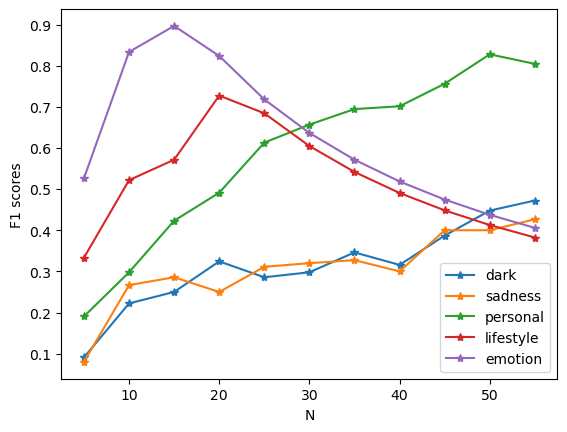

In [ ]:
# choose an appropriate value for N based on how you think the songs will be presented.
M = 20
topic_scores = {}
for N in range(5, 60, 5):
    result, scores = get_topN_recommend_by_topM_words(train_df, test_df, user1_keywords, M, N, verbose=False)
    for topic in scores.keys():
        if topic not in topic_scores:
            topic_scores[topic] = []
        topic_scores[topic].append(scores[topic])

plt.figure()
for topic in topic_scores.keys():
    plt.plot(range(5, 60, 5), topic_scores[topic], marker='*',label=topic)
plt.xlabel("N")
plt.ylabel("F1 scores")
plt.legend()
plt.show()

In [ ]:
test_df['topic'].value_counts()

topic
dark         81
sadness      69
personal     51
lifestyle    32
emotion      17
Name: count, dtype: int64

_Comment_

In the above figure, the horizontal axis is the number of recommended songs N, and the vertical axis is the F1 score. Each curve represents a different topic (dark, sadness, personal, lifestyle, emotion).

The recommender performs differently under different topics. \
emotion: The best performance, the F1 score reaches a peak (close to 0.9) when N is small (15), and then decreases as N increases. N is close to the number of songs that users are actually interested in under this topic.\
lifestyle: The F1 score rises rapidly as N increases, reaches a peak (about 0.7) at around 20, and then gradually decreases.\
personal: The F1 score continues to rise as N increases, and performs best (close to 0.8) when N is large (50), and N is close to the number of songs that users are actually interested in under this topic.\
dark and sadness: The F1 scores of these two topics are generally low, but they both increase slowly as N increases. This is probably because the number of songs that users are actually interested in under these two topics exceeds 60.

From the previous results, it can be inferred that F1 is mainly affected by low recall, so it will reach its highest value when N increases to more than half of the number of songs that users are actually interested in.

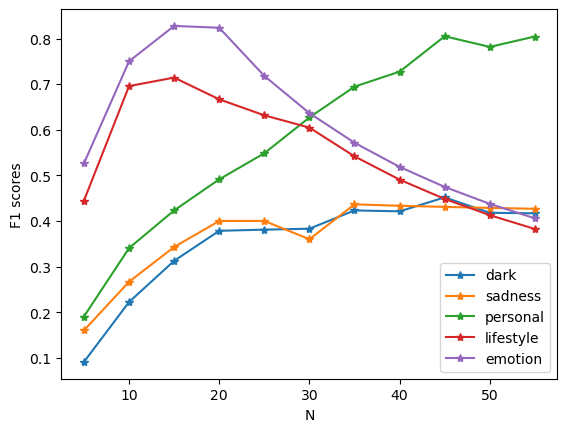

In [ ]:
# consider various values for M, the number of words in the user profile for each topic, compared to using all words.
M = best_N  # 300
topic_scores = {}
for N in range(5, 60, 5):
    result, scores = get_topN_recommend_by_topM_words(train_df, test_df, user1_keywords, M, N, verbose=False)
    for topic in scores.keys():
        if topic not in topic_scores:
            topic_scores[topic] = []
        topic_scores[topic].append(scores[topic])

plt.figure()
for topic in topic_scores.keys():
    plt.plot(range(5, 60, 5), topic_scores[topic], marker='*',label=topic)
plt.xlabel("N")
plt.ylabel("F1 scores")
plt.legend()
plt.show()

_Comment_

Compared to M=20, when using all words (M=300), the optimal N for all topics except emotion decreases. This is because when judging the songs that actual users like, we compare whether the keywords appear in the song's document. When the profile words increase, the possibility of covering keywords becomes greater, which is closer to the result of judging the songs that actual users like.

__Part 3. User Evaluation__

In [ ]:
N = 10
# show user 3 randomly chosen batches of N songs for the first three weeks
train_data = []
for week in range(3):
    week_df = df.iloc[week*250:(week+1)*250]
    sample = week_df.sample(N, random_state=week)
    print(f"Week {week+1}:")
    display(sample[['artist_name', 'track_name', 'release_date', 'genre', 'lyrics']].reset_index())
    train_data.extend(sample['document'].tolist())

Week 1:


,index,artist_name,track_name,release_date,genre,lyrics
0,225,all them witches,internet,2017,blues,guess live internet time outsource lightning s...
1,122,derek b,bullet from a gun,2016,hip hop,boot breathe hole drive river watch tear eye c...
2,92,mike ryan,the rewrite,2017,country,write song kind make soft sweet like faithfull...
3,157,billie eilish,all the good girls go to hell,2019,pop,lucifer lonely stand kill time commit crime va...
4,154,black lips,crystal night,2017,blues,remember snow fall hold arm kiss think novembe...
5,161,uncle kracker,rescue,2019,country,stay late night nothin drink help drink mind l...
6,198,guts,peaceful life,2016,jazz,danger start futile think server laws conceiva...
7,83,l'indécis,the god behind the pines,2017,jazz,come come come cry loud run comedown forbid kn...
8,63,banes world,you say i'm in love,2017,pop,unafraid know hear tone dust coat rain come mo...
9,155,buczer,hip hop prod. crackhouse,2017,hip hop,ghost porcelain waste innocence translucent ey...


Week 2:


,index,artist_name,track_name,release_date,genre,lyrics
0,317,joe corfield,shimmer,2016,jazz,heaven heaven mater nights raise sword holy bl...
1,499,greyhound,i am what i am,2018,reggae,people scheme dream people live live look worl...
2,480,bastille,million pieces,2019,rock,million piece breathe hard speak cause like bi...
3,411,filmore,heart's having a hard time,2018,country,think weight chest night say couldn think brea...
4,341,ty segall,body behavior,2018,blues,pick sewer train future come inside inside dee...
5,474,gary clark jr.,pearl cadillac,2019,blues,nothin world somethin nothin thank beautiful g...
6,308,thee oh sees,the daily heavy,2019,blues,stop baby tear asunder shove go live stuff plu...
7,484,gregory porter,holding on,2016,jazz,weight shoulder think easier heart grow colder...
8,430,don philippe,the world connects,2016,jazz,buju banton yout brownin song hear tell cause ...
9,254,xavier rudd,fly me high,2018,reggae,come eye smile shine days heart strong kindnes...


Week 3:


,index,artist_name,track_name,release_date,genre,lyrics
0,589,the dillinger escape plan,limerent death,2016,jazz,amaze reinforce guard cause deep inside mista...
1,591,eric church,hippie radio,2018,country,daddy pontiac beigeer yellow young little fell...
2,593,hirie,good vibration (feat. trevor hall),2016,reggae,repel pride material hype deep earth dirt coll...
3,724,george duke,"the morning, you & love",2019,jazz,morning morning worry morning come
4,626,nahko and medicine for the people,runner,2016,reggae,runner run things good things ahead kind lover...
5,741,weldon irvine,morning sunrise,2016,jazz,morning sunrise morning sunrise hello morning ...
6,731,dorothy,philadelphia,2018,blues,plane tease feel sixteen fine friends notice c...
7,530,the lumineers,donna,2019,rock,word save picture hair braid wallet cemetery t...
8,535,cyrille aimee,loving you,2019,jazz,love choice love choice reason rejoice give pu...
9,639,vampire weekend,sympathy,2019,rock,think bedroom firmly take hand isolation end b...


In [ ]:
# collect feedbacks from a friend
liked_ids = [0, 1, 5, 8, 9, 10, 11, 13, 18, 19, 21, 23, 28]  # select liked songs from songs 0-29 (three batches)

In [ ]:
# build tfidf vectorizer on train_df(best_N=300)
vect = TfidfVectorizer(max_features=best_N).fit(train_df['document'])

# get tfidf vector of songs that user like
docs = " ".join([doc for i,doc in enumerate(train_data) if i in liked_ids])
tfidf = vect.transform([docs])

# get profile words
M = 20
words = vect.get_feature_names_out()
scores = tfidf.toarray()[0]  # to develop user profile
top_indices = scores.argsort()[-20:][::-1]  # which consists of top M words ranked according to tfidf scores
profile_words = [words[i] for i in top_indices]
print("user profile:", ", ".join(profile_words)) 

# get recommendations for week 4
recommends = {}  # idx->score
for idx, row in test_df.iterrows():
    doc_words = row['document'].split()

    # similarity score: sum of tf
    score = sum(doc_words.count(w) for w in profile_words)
    recommends[idx]=score
    
# get the recommend list
result = {}
sorted_iscore = sorted(recommends.items(), key=lambda x: x[1], reverse=True)
recommend_list = [x[0] for x in sorted_iscore[:N]]

# show the recommened N songs
test_df.loc[recommend_list, ['artist_name', 'track_name', 'release_date', 'genre', 'lyrics']].reset_index()

user profile: live, black, woman, heart, love, babi, peopl, leav, hard, right, stop, caus, come, away, time, high, fool, pain, look, think


,index,artist_name,track_name,release_date,genre,lyrics
0,989,solange,cranes in the sky,2016,pop,try drink away try try dance away try change h...
1,952,jonas brothers,don't throw it away,2019,pop,picture frame pack things help week get like c...
2,866,larkin poe,black betty,2017,blues,whoa black bambalam whoa black bambalam black ...
3,766,kygo,remind me to forget,2017,pop,fade away stay kiss like break glass skin grea...
4,836,sublime with rome,blackout,2019,reggae,yeah yeah yeah yeah yeah want nights feel nice...
5,851,tedeschi trucks band,hard case,2019,blues,learn lose guess hold candle singers blue hard...
6,907,harry styles,sign of the times,2017,pop,stop cry sign time welcome final wear best clo...
7,981,elvin bishop,(your love keeps lifting me) higher and higher,2018,blues,time better bite tongue think twice open mouth...
8,991,grouplove,good morning,2017,rock,live wide awake yeah stranger addict self rear...
9,884,alborosie,rocky road,2016,reggae,road road road road life cycle time waste life...


In [ ]:
# collect feedbacks from the friend
recommend_liked_ids = [0, 3, 4, 6, 7]

In [ ]:
# calculate metrics
metrics = []
# scores = []
for N in range(1, 10):
    recommend_list = list(range(N))
    true_positives = len([1 for i in recommend_list if i in recommend_liked_ids])  # number of relevant docs in recommendations           
    precision = true_positives/N
    metrics.append((f"Precision@{N}", round(precision,3)))
    
pd.DataFrame(metrics, columns=["Metric", "Score"])

,Metric,Score
0,Precision@1,1.000
1,Precision@2,0.500
2,Precision@3,0.333
3,Precision@4,0.500
4,Precision@5,0.600
5,Precision@6,0.500
6,Precision@7,0.571
7,Precision@8,0.625
8,Precision@9,0.556


_Comment_

The evaluation index selected in part 3 is Precision@N, which is to calculate the precision when N songs are recommended. Unlike the evaluation in part 2, we do not know the actual users' favorite songs in all the test data, so we cannot calculate the Recall and F1 values. From the results in the table above, when only one song is recommended, the Precision value is the highest, followed by N=8 and N=5.